In [1]:
# Setup code for the notebook
#%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import ipytools
import data_loader
import visualization

# Get test datas

In [3]:
images_name = [
    '../testdata/input_pair/img_01.tif',
    '../testdata/input_pair/img_02.tif'
]

In [4]:
rpc_name = [
    '../testdata/input_pair/rpc_01.xml',
    '../testdata/input_pair/rpc_02.xml'
]

In [5]:
roi = {
"x": 150,
"y": 150,
"w": 700,
"h": 700
}

In [6]:
roi = None

In [7]:
tile_size = 300

# Get images from the video 

In [4]:
folders = data_loader.retrieve_video()

892 images


In [5]:
# Chose a pair of images
i, j = 0, 100
images_name = data_loader.choose_video(folders, [i, j])

In [6]:
images_name

['../data/s02_20150507T020554Z/video_frames/s02_20150507T02055427Z.tif',
 '../data/s02_20150507T020554Z/video_frames/s02_20150507T02055760Z.tif']

In [64]:
roi = {
    "x": 0,
    "y": 0,
    "w": 1000,
    "h": 1000
  }

In [6]:
roi = None

In [8]:
tile_size = 1000
rpc_name = []

# Get Triplets

In [3]:
folders = data_loader.retrieve_triplets()

In [4]:
# Chose a pair of images
d = 2
i = 9
indices = ['1107', '1148']#, '1231']
images_name = data_loader.choose_triplets(folders, d, i, indices)

In [5]:
roi = {
    "x": 0,
    "y": 0,
    "w": 1000,
    "h": 1000
  }

In [6]:
tile_size = 1000
rpc_name = []

# Visualize chosen images

Dimension:  (1024, 1024, 1)
Dimension:  (1102, 1031, 1)



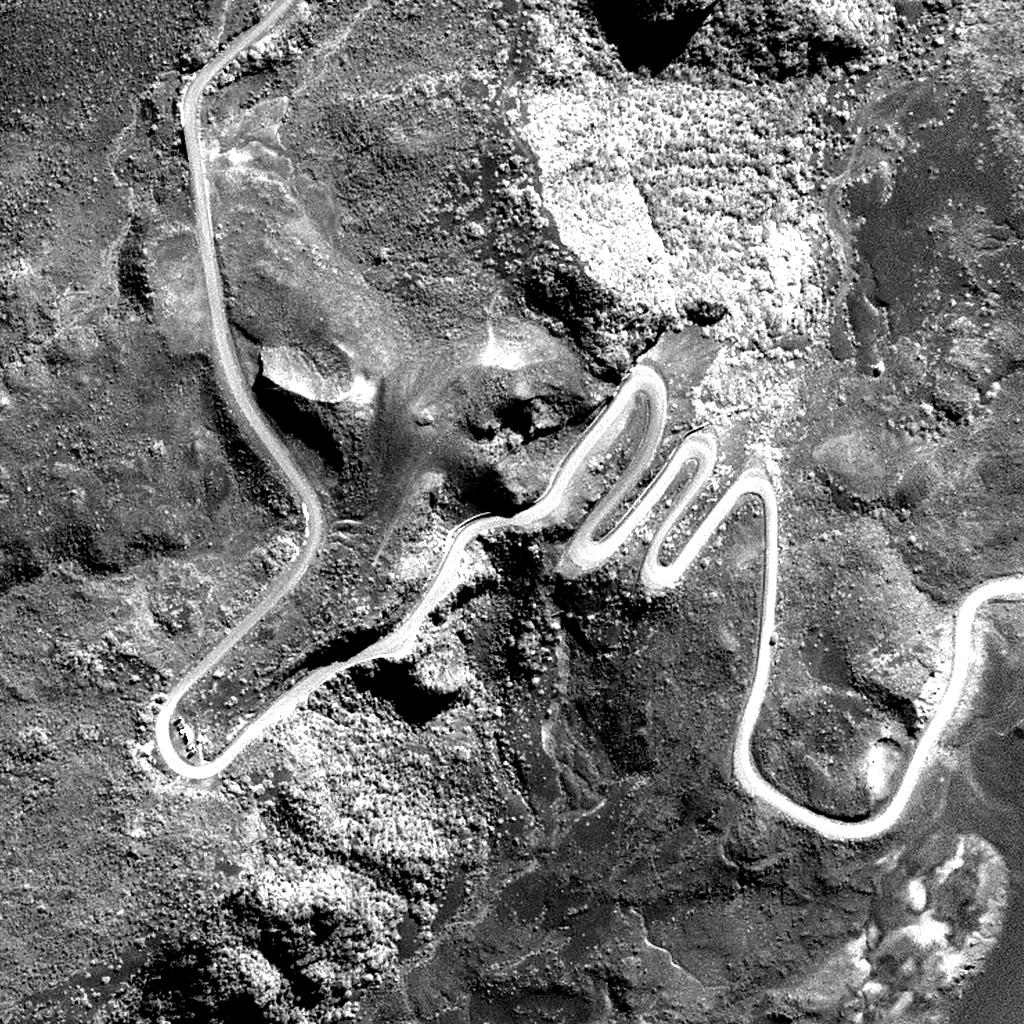
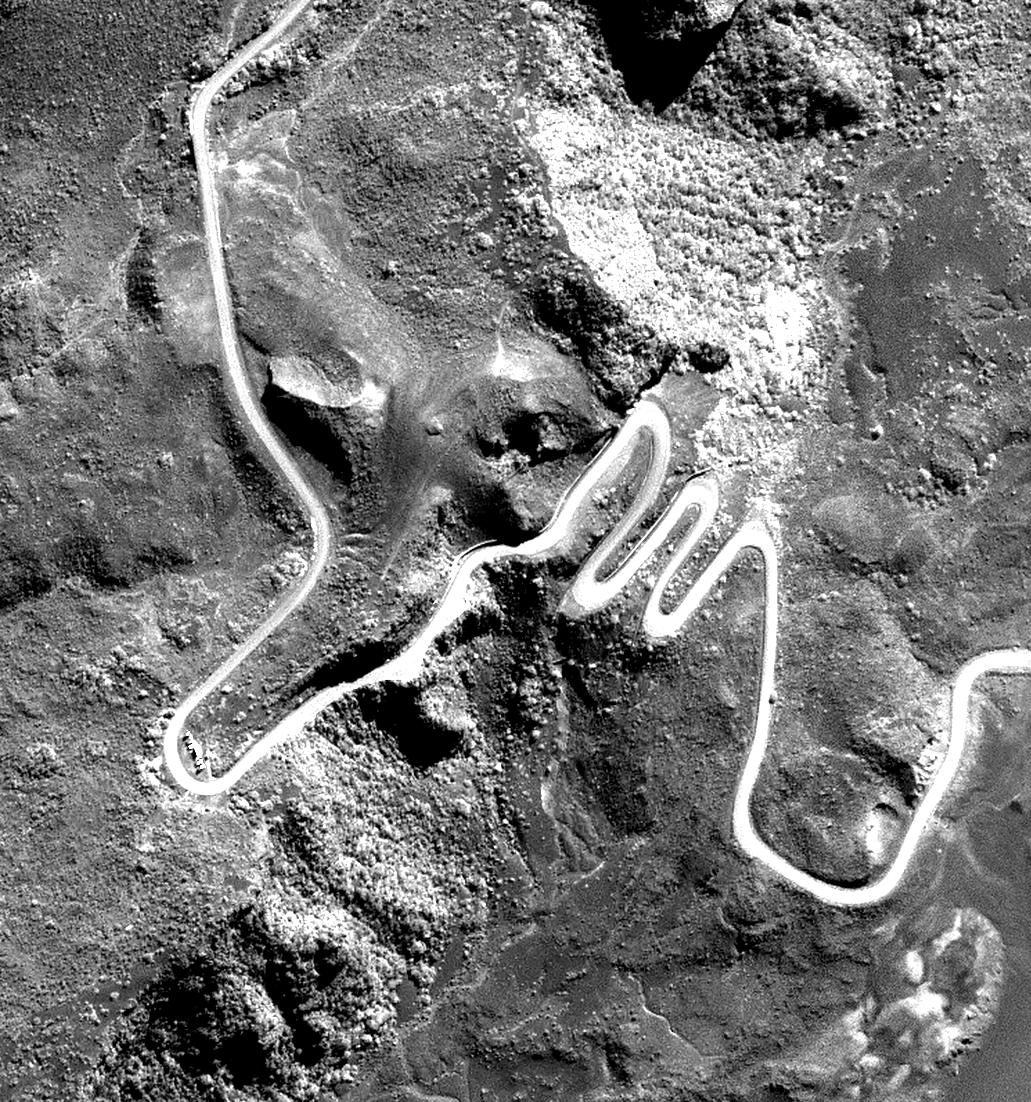

In [8]:
data_loader.display_images(images_name)

Dimension:  (1024, 1024, 1)
Dimension:  (1102, 1031, 1)



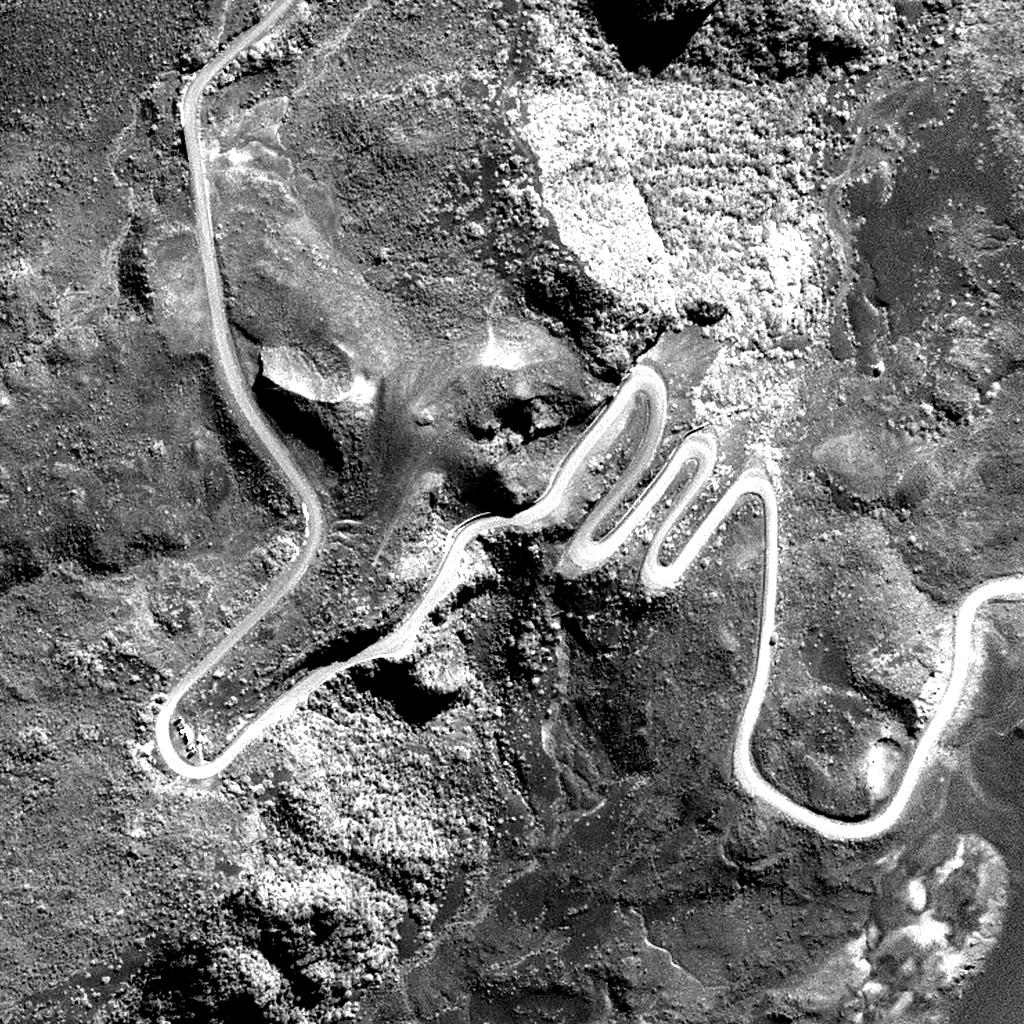
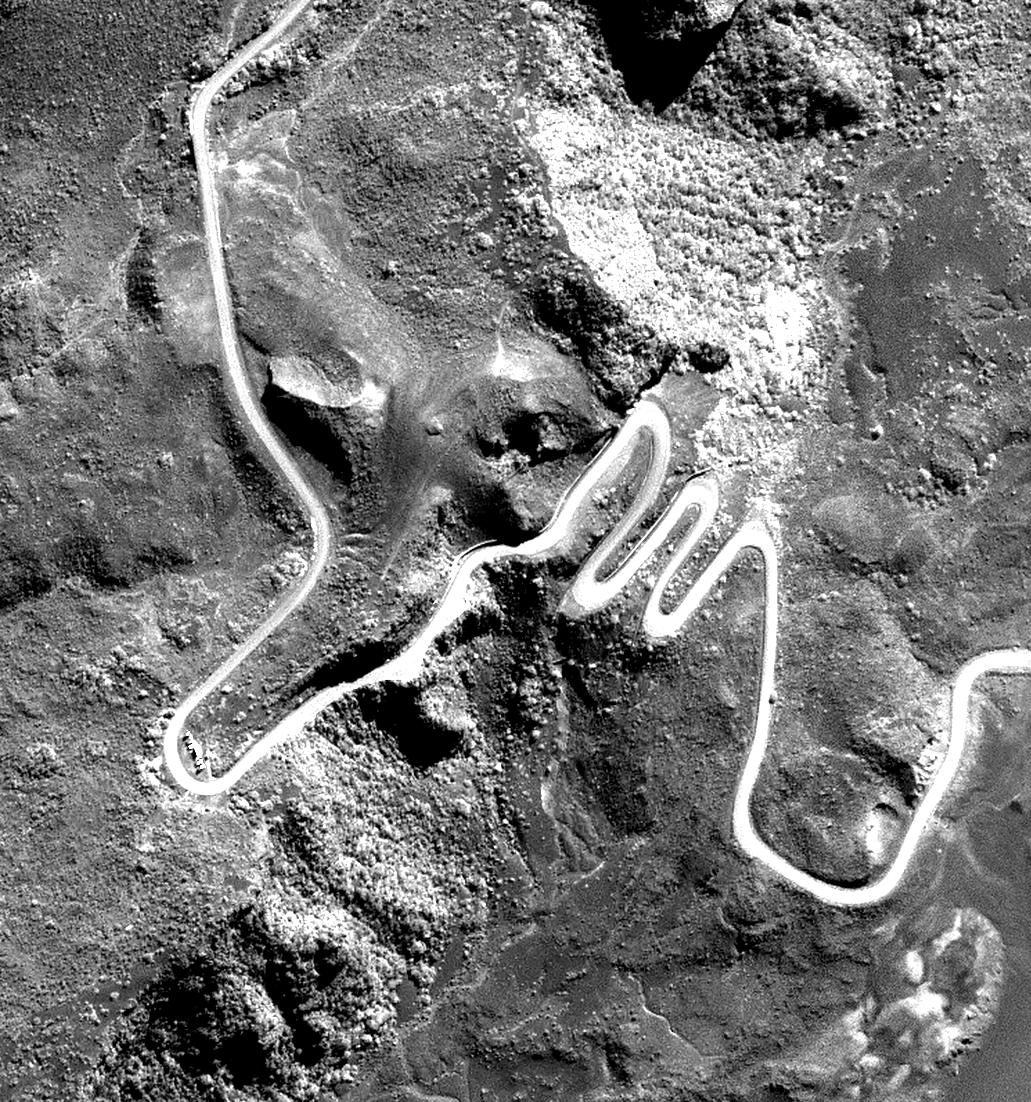

In [8]:
data_loader.display_images(images_name, roi)

# Compare optimizations

In [9]:
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import numpy as np
def compare(images_name, tile_size=tile_size, roi=None, rpc_name=[]):
    A_list = []
    init_scores = []
    corrected_scores = []
    for i in tqdm([('analytic', 1, False), ('numeric', 1, True), ('numeric', 1, False), ('numeric', 2, True), ('numeric', 2, False)]):#, ('analytic', 2)]
        opti_method, num_variable, apply_rectification = i
        # Write JSON
        data_loader.write_json(images_name, opti_method=opti_method, num_variable=num_variable, 
                               apply_rectification=apply_rectification, 
                               tile_size=tile_size, roi=roi, rpc_name=rpc_name)
        # Excute s2P
#         !rm yaw_extension/test.txt &> /dev/null
        !rm -rf output && cd .. && python3 s2p.py yaw_extension/config.json &> yaw_extension/test.txt
        # tiles path
        tiles_path = visualization.get_tiles_path()
        A_paths = []
        init_scores_path = []
        corrected_scores_paths = []
        for j in range(len(tiles_path)):
            tile_path = tiles_path[j]
            # Retrieves transformation matrix 
            m = visualization.get_matches(tile_path)
            F = visualization.get_affine_fundamental_matrix(tile_path)
            A = visualization.get_correction_matrix(tile_path)
            A_paths.append(A)
            # Compute errors 
            e_2, e_3 = visualization.visualize_pointing_error(F, m, A, plot=False)
            init_scores_path.append(e_2)
            corrected_scores_paths.append(e_3)
        A_list.append(A_paths)
        init_scores.append(init_scores_path)
        corrected_scores.append(corrected_scores_paths)
    return A_list, np.array(init_scores), np.array(corrected_scores)

In [ ]:
A_list, init_scores, corrected_scores = compare(images_name, tile_size=tile_size, roi=roi, rpc_name=rpc_name)

 40%|████      | 2/5 [01:34<02:21, 47.08s/it]

In [14]:
float_formatter = lambda x: "%.1f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [15]:
init_scores

array([[186.9, 82.0, 544.4],
       [186.9, 82.0, 544.4],
       [186.9, 82.0, 544.4],
       [186.9, 82.0, 544.4],
       [186.9, 82.0, 544.4]])

In [16]:
np.array(corrected_scores)

array([[110.4, 79.5, 63.8],
       [110.4, 79.5, 63.8],
       [110.4, 79.5, 63.8],
       [97.4, 81.0, 43.7],
       [75.6, 81.0, 43.7]])

In [90]:
A_list

[[array([[1.        , 0.        , 1.73151257],
         [0.        , 1.        , 0.35584926],
         [0.        , 0.        , 1.        ]])],
 [array([[1.        , 0.        , 1.73151256],
         [0.        , 1.        , 0.35584926],
         [0.        , 0.        , 1.        ]])],
 [array([[1.        , 0.        , 1.73144022],
         [0.        , 1.        , 0.35620131],
         [0.        , 0.        , 1.        ]])],
 [array([[ 9.99974410e-01,  7.15402691e-03, -1.29292390e-05],
         [-7.15402691e-03,  9.99974410e-01, -2.56087000e-06],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])],
 [array([[ 9.99974410e-01,  7.15402676e-03, -1.29174190e-05],
         [-7.15402676e-03,  9.99974410e-01, -2.62164700e-06],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])]]

# Execution of s2p on Plantet's data

In [7]:
data_loader.write_json(images_name, opti_method='numeric', num_variable=2, apply_rectification=False, tile_size=tile_size, roi=roi, rpc_name=rpc_name)

In [8]:
!rm -rf output && cd .. && python3 s2p.py yaw_extension/config.json

out_dir is: /Users/juleskozolinsky/Projets/s2p/yaw_extension/./output
tile size: 1000 1000
total number of tiles: 1 (1 x 1)

discarding masked tiles...
done 1 / 1 tiles
Elapsed time: 0:00:00.156346

correcting pointing locally...
correcting pointing on tile 0 0 pair 1...

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/yaw_extension/../data/s03_20161003T161107Z/panchromatic/s03_20161003T161107Z_pan_d2_0009.tif 0 0 1000 1000 --thresh-dog 0.013300 -o /tmp/s2p_j4a515jz.txt
0:00:01.934151

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/yaw_extension/../data/s03_20161003T161148Z/panchromatic/s03_20161003T161148Z_pan_d2_0009.tif -338 141 1276 1844 --thresh-dog 0.013300 -o /tmp/s2p_k98v5rh6.txt
0:00:02.030633

RUN: matching /tmp/s2p_j4a515jz.txt /tmp/s2p_k98v5rh6.txt -relative 0.600000 -o /tmp/s2p_dm2u46d9.txt -f "0.6356348955768358 0.13063157249970264 -0.741352968484693 -0.1711708150071561 126.75778249102905"
21 matches
0:00:01.706542

RUN: ransac fmn 1000 .3 7 /tmp/s2p_dm2u46d9.txt < /tm

In [9]:
tiles_path = visualization.get_tiles_path()
print(tiles_path)
tile_path = tiles_path[0]

['./output/tiles/row_0000000_height_1000/col_0000000_width_1000/pair_1']


# Retrieve computed values

In [10]:
im_list = visualization.get_images()
im1 = im_list[0]
im2 = im_list[1]

../data/s03_20161003T161107Z/panchromatic/s03_20161003T161107Z_pan_d2_0009.tif
../data/s03_20161003T161148Z/panchromatic/s03_20161003T161148Z_pan_d2_0009.tif


In [11]:
m = visualization.get_matches(tile_path)
F = visualization.get_affine_fundamental_matrix(tile_path)
A = visualization.get_correction_matrix(tile_path)
print(A)

[[ 9.99974410e-01  7.15402676e-03 -1.29174190e-05]
 [-7.15402676e-03  9.99974410e-01 -2.62164700e-06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


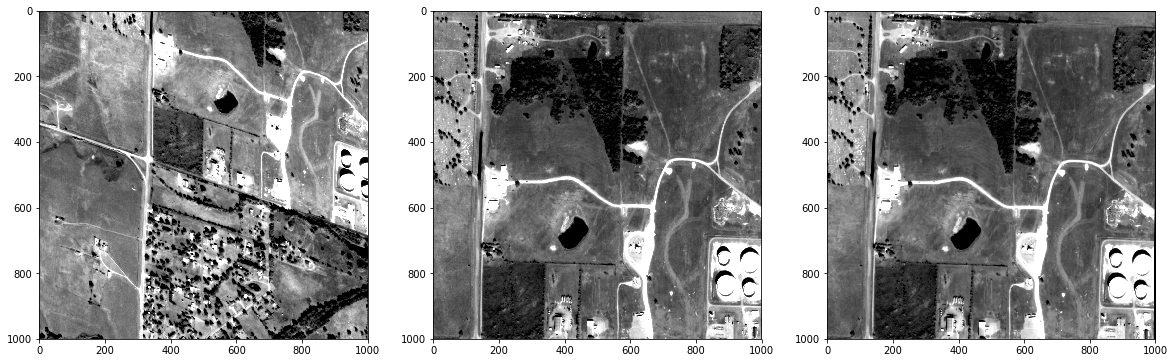

In [12]:
im2_corrected = visualization.visualize_transformation(im1, im2, A)

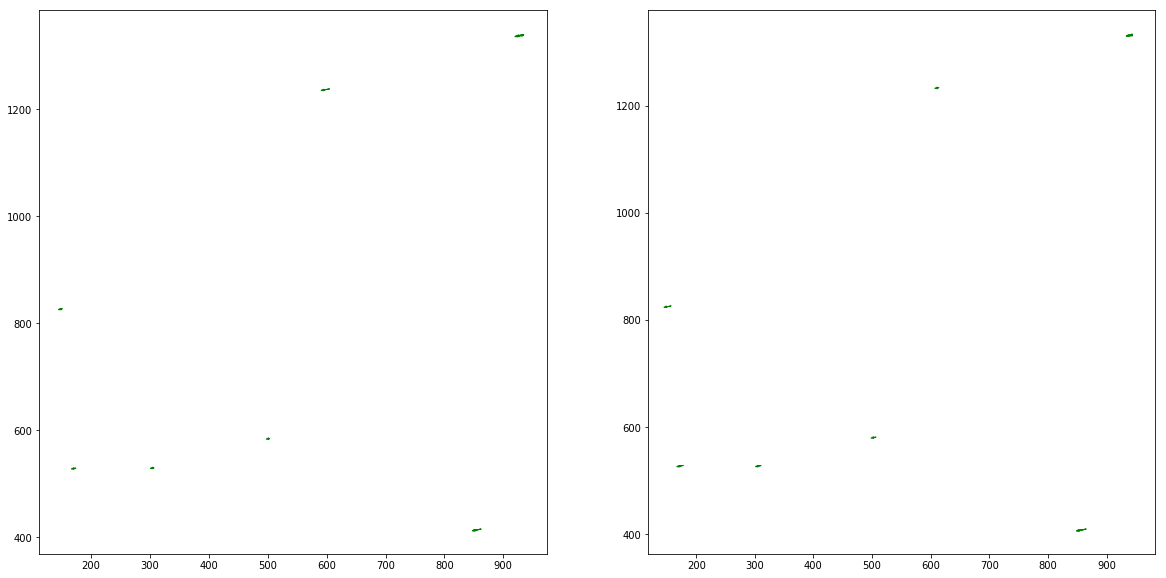

In [13]:
%matplotlib inline
e_2, e_3 = visualization.visualize_pointing_error(F, m, A)

In [14]:
print("error without pointing error correction:", e_2)
print("error with pointing error correction:", e_3)

error without pointing error correction: 78.60932317807965
error with pointing error correction: 65.97892525219476


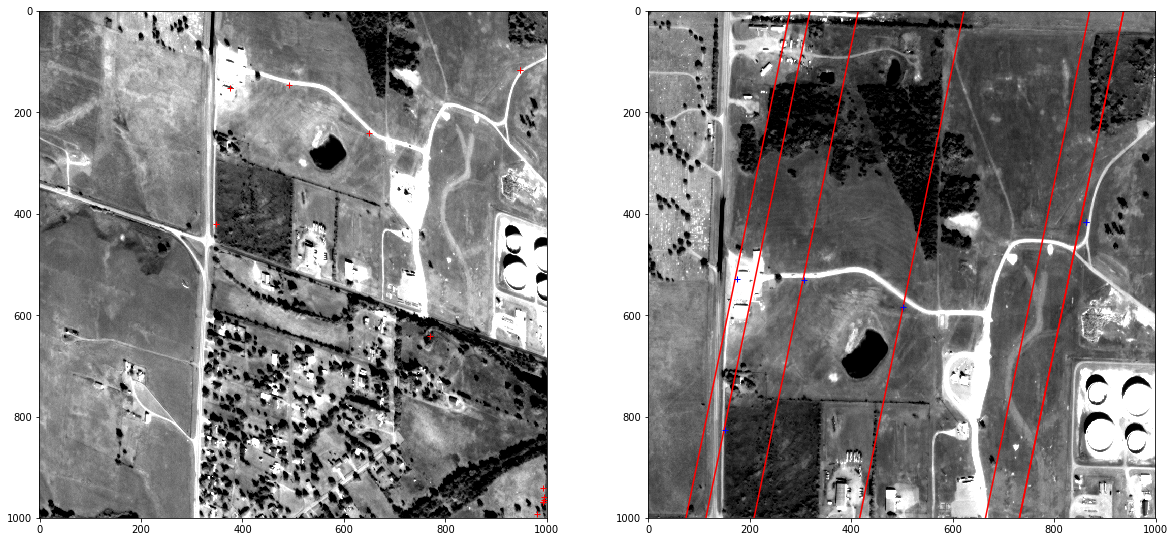

In [15]:
visualization.visualize_epipolar(im1, im2, F, m)

In [69]:
m

array([[692.352, 509.606, 693.897, 557.688],
       [507.553, 518.957, 513.425, 548.167],
       [715.46 , 538.378, 716.281, 590.854],
       [636.226, 543.139, 638.433, 587.719],
       [530.403, 544.411, 535.295, 576.796],
       [625.478, 548.972, 627.853, 591.394],
       [537.52 , 556.048, 541.658, 591.772],
       [610.695, 558.895, 613.265, 599.802],
       [617.368, 559.936, 620.178, 601.951],
       [615.691, 562.683, 618.302, 604.824],
       [550.055, 570.693, 553.437, 610.643],
       [601.082, 570.274, 603.837, 611.54 ],
       [596.663, 583.597, 598.979, 626.717],
       [676.656, 586.611, 677.736, 635.426],
       [619.128, 587.157, 620.967, 633.808],
       [669.923, 588.906, 670.804, 637.591],
       [588.095, 594.019, 590.493, 638.473],
       [619.664, 603.142, 620.985, 651.898],
       [667.72 , 606.219, 668.606, 657.317],
       [667.72 , 606.219, 668.606, 657.317],
       [660.814, 608.289, 661.582, 659.178],
       [562.159, 610.703, 564.149, 657.504],
       [57


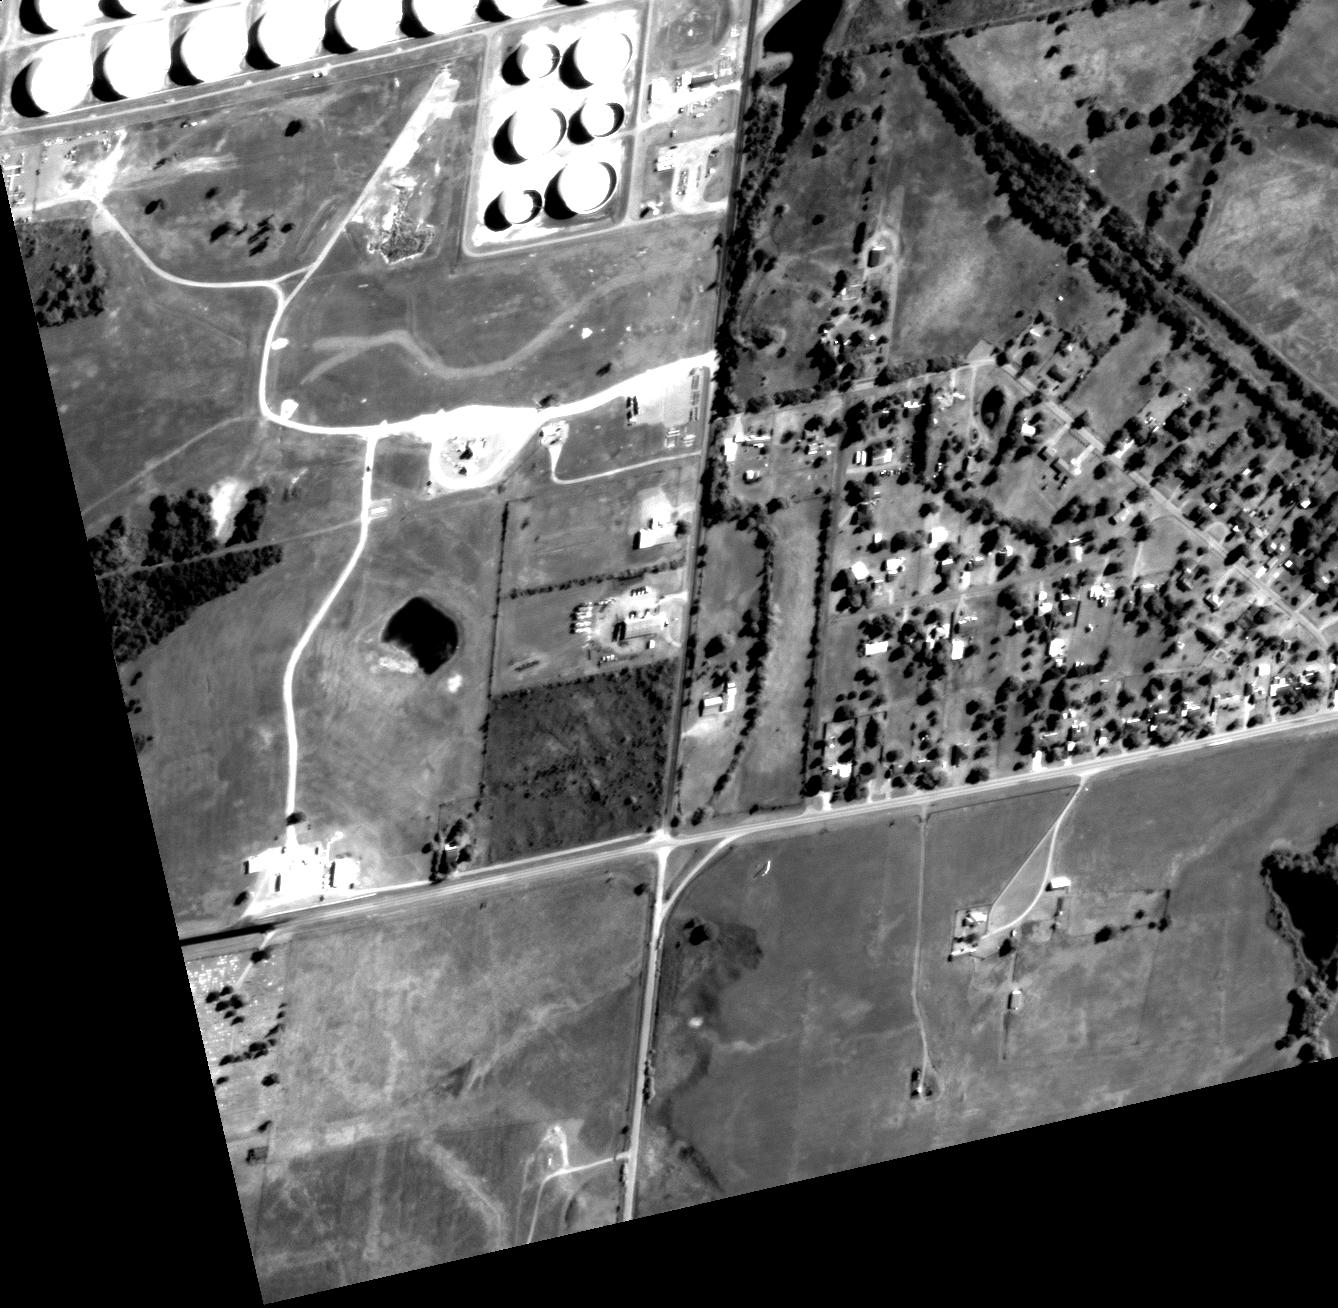
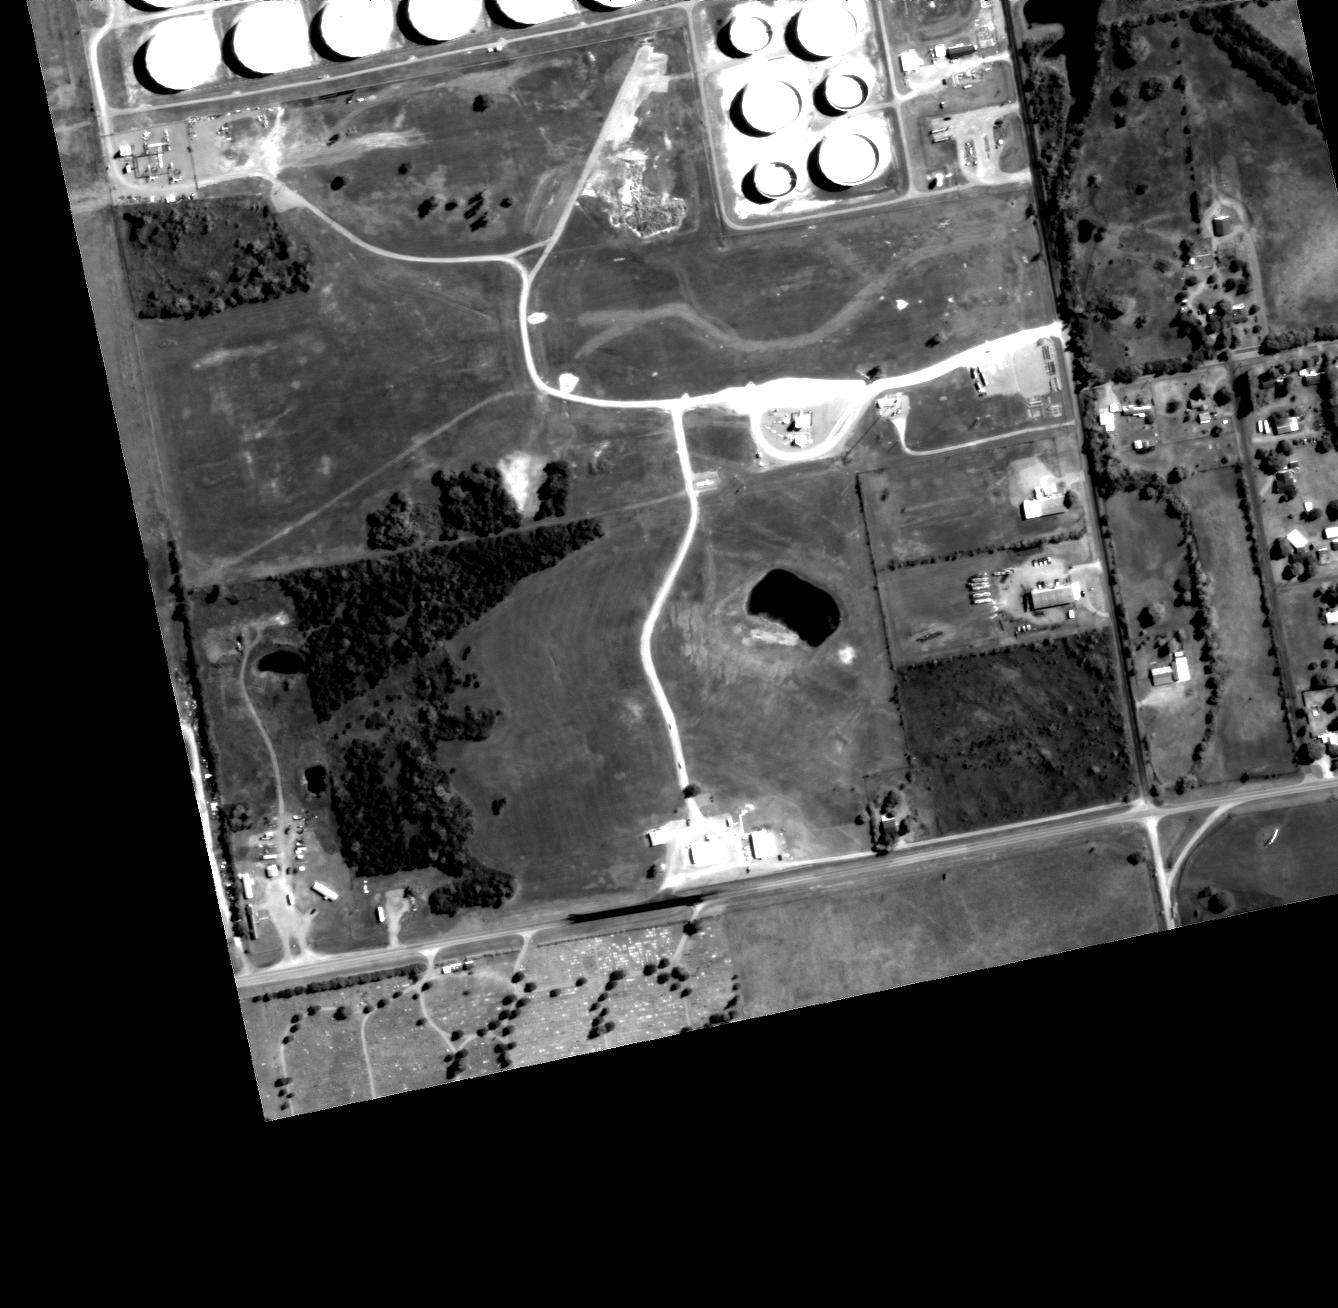

In [16]:
a_ref = tile_path + '/rectified_ref.tif'
a_sec = tile_path + '/rectified_sec.tif'
ipytools.display_gallery([ipytools.simple_equalization_8bit(ipytools.readGTIFF(a_ref)), ipytools.simple_equalization_8bit(ipytools.readGTIFF(a_sec))])

In [88]:
ipytools.display_imshow(ipytools.simple_equalization_8bit(ipytools.readGTIFF(a_ref)))

NameError: name 'a_ref' is not defined

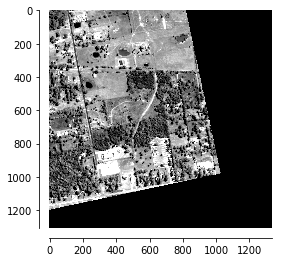

In [220]:
ipytools.display_imshow(ipytools.simple_equalization_8bit(ipytools.readGTIFF(a_sec)))

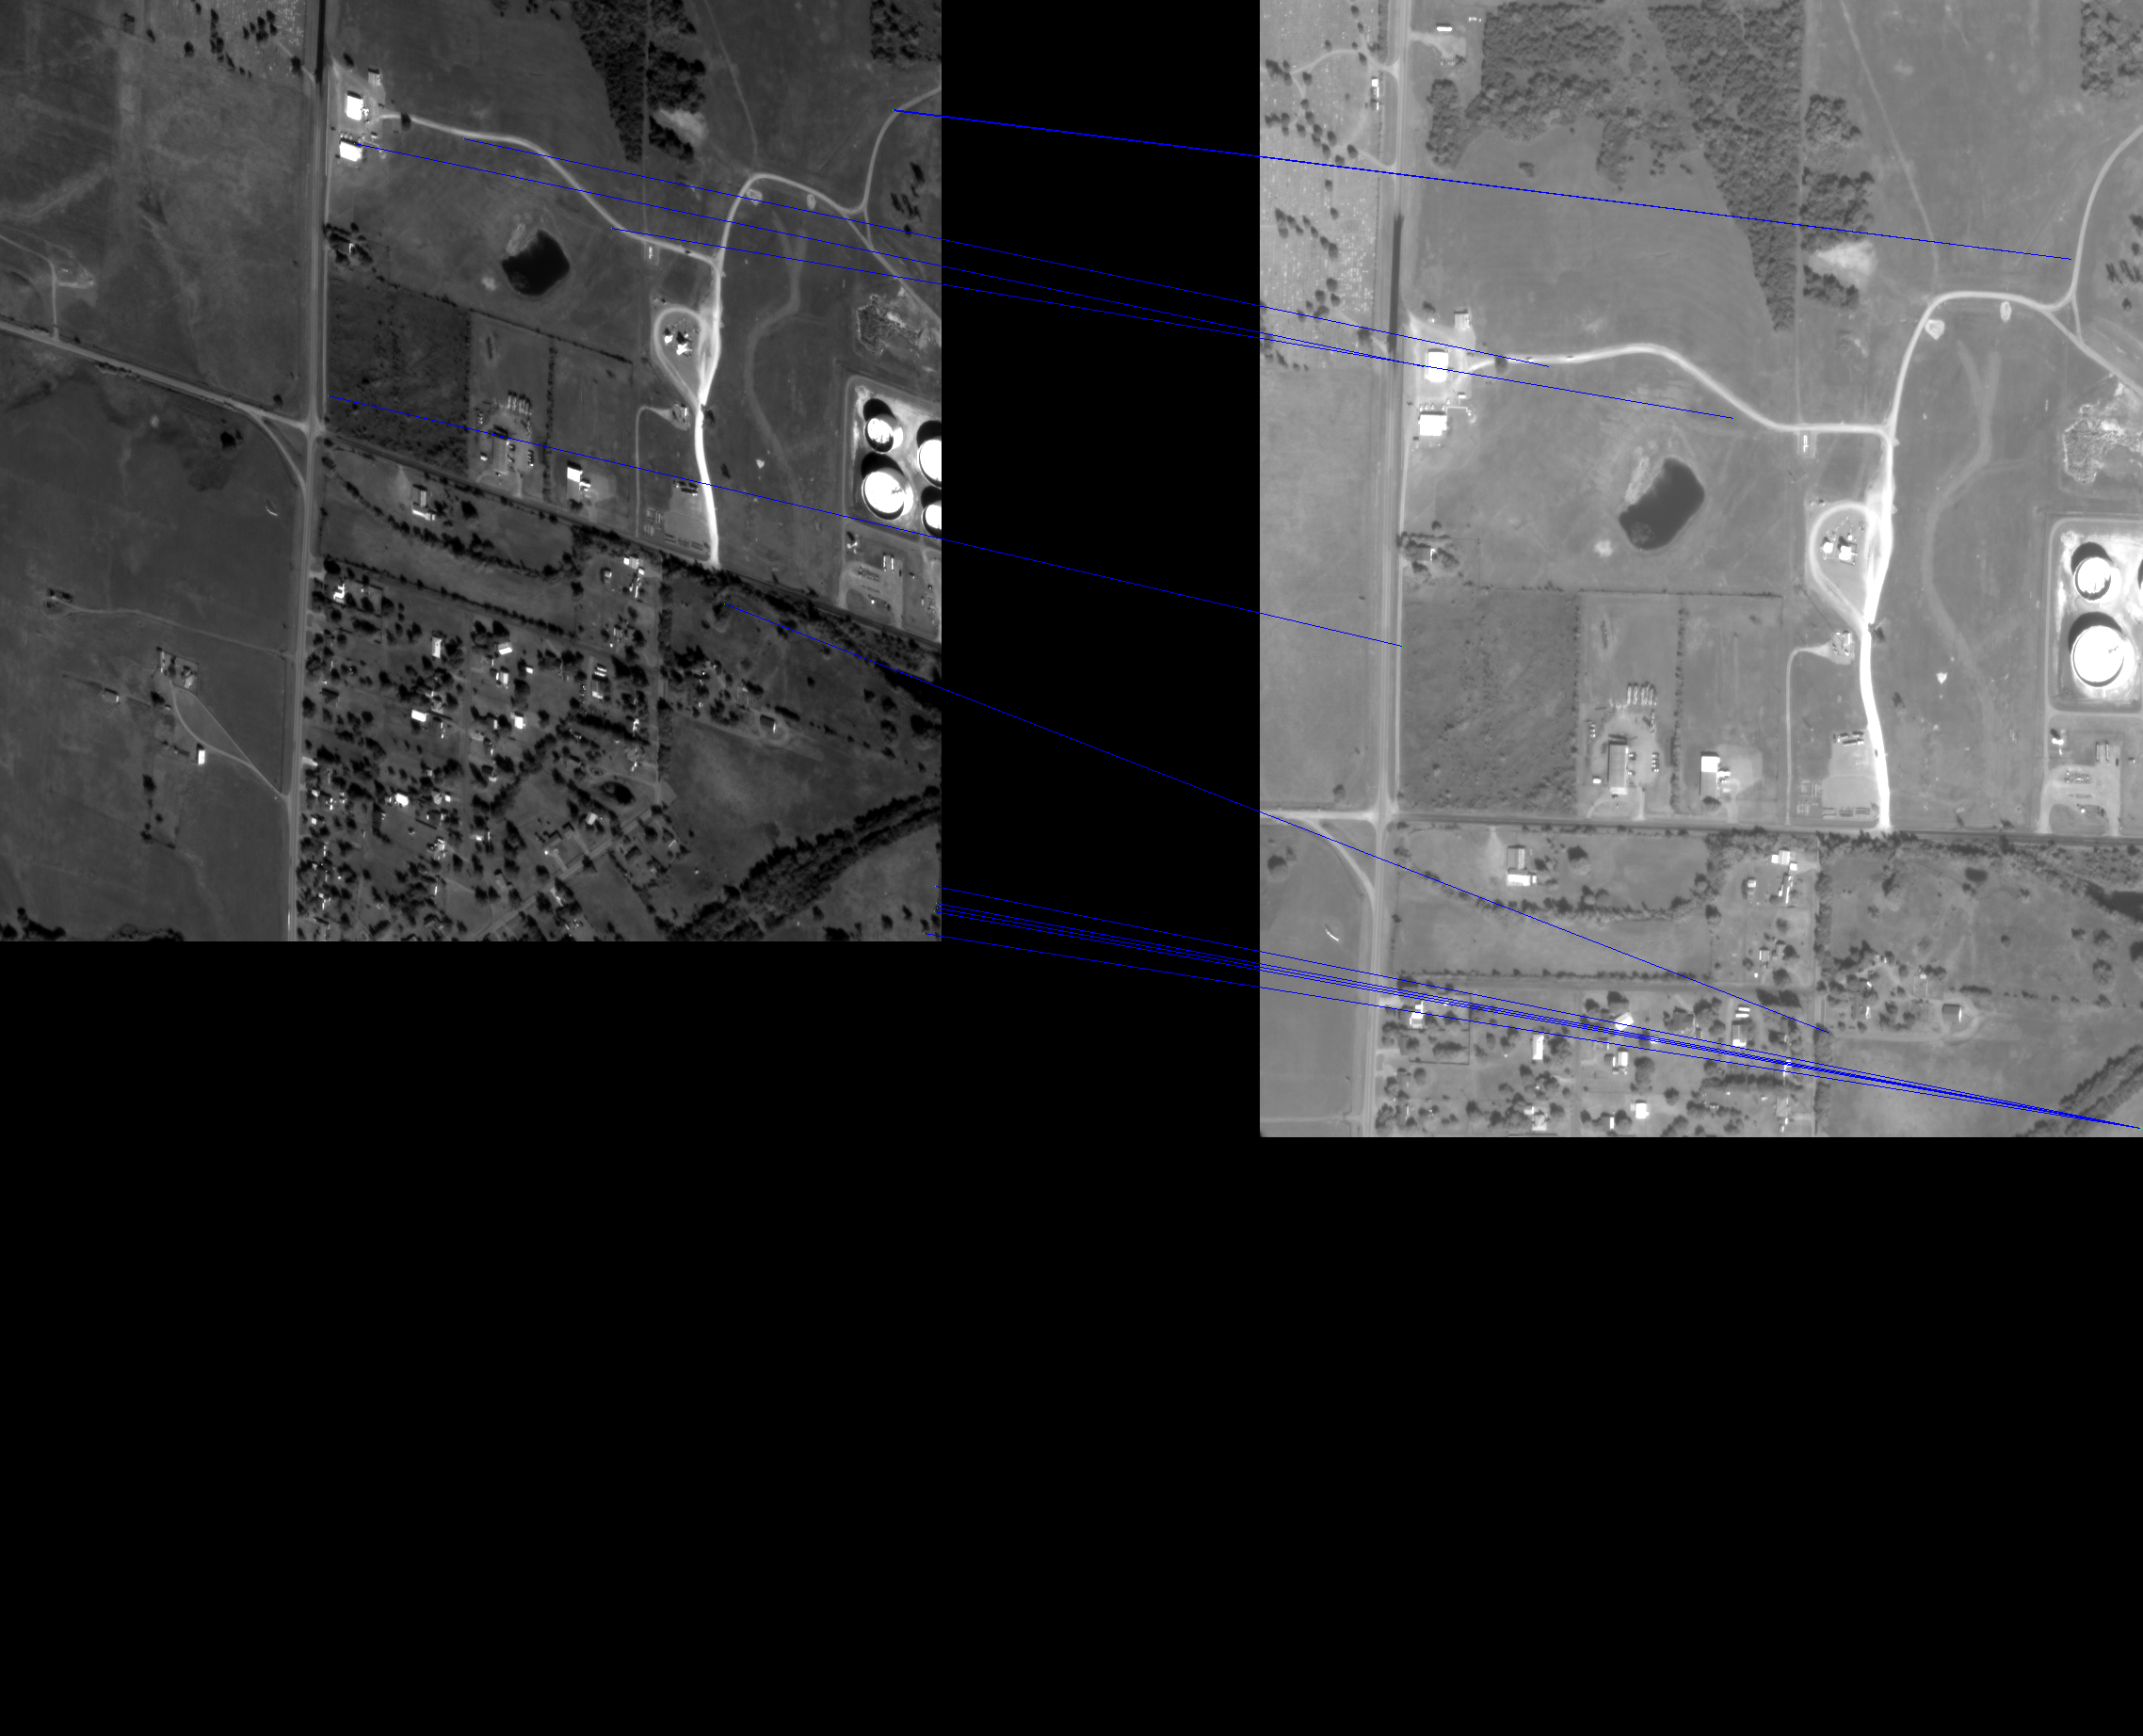

In [113]:
from IPython.display import Image
filename = tile_path + '/sift_matches_pointing.png'
Image(filename=filename) 

In [106]:
expected_output = './output/s03_20161003T161107Z/dsm.tif'
a = readGTIFF(expected_output)

RasterioIOError: ./output/s03_20161003T161107Z/dsm.tif: No such file or directory

<IPython.core.display.Javascript object>


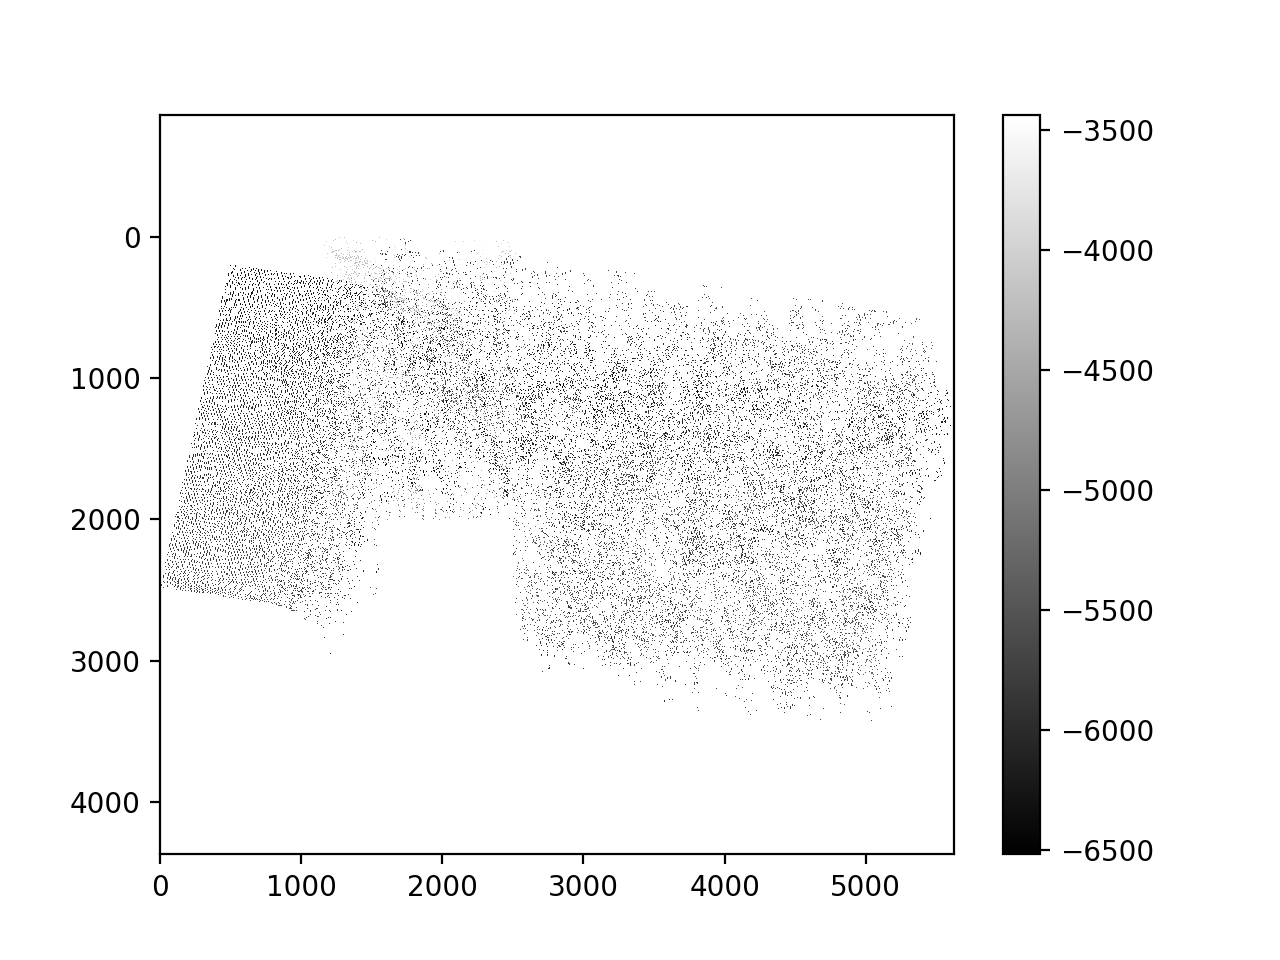

In [18]:
b = a#readGTIFF('/Users/juleskozolinsky/Projets/s2p/yaw_extension/output/s03_20161003T161107Z/tiles/row_0000000_height_500/col_0001000_width_500/dsm.tif')
display_imshow(b)